# Assignment 3

## Multiple Linear Regression and Multi-collinearity
In this assignment, we'll be using the **Iris Dataset** for a multiple linear regression model. 

**Dependent Feature:** Petal Width

**Independent Features:** Sepal Length, Petal Length

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Importing Data from CSV File
Using PANDAS to import data from iris.csv

In [2]:
data = pd.read_csv("iris.csv")

In [3]:
Y = data["petal_width"].values  # Dependent variable

X1 = data["sepal_length"].values
X2 = data["petal_length"].values

print('Sepal Length & Petal Length chosen as the indepent variables\nPetal width chosen as the dependent variable')

Sepal Length & Petal Length chosen as the indepent variables
Petal width chosen as the dependent variable


## Multi-linear Model
Combining the two independent variables to make a **matrix** for our multi-linear model

In [4]:
# Making a matrix named X, which will server as our independent feature

X = np.vstack((X1, X2)).T

In [5]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sigma=10)
    β1 = pm.Normal('β1', mu=0, sigma=10)
    β2 = pm.Normal('β2', mu=0, sigma=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]   # α + (β1 * X1) + (β2 * X2)

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=Y)

    idata_x1x2 = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α, β1, β2, ϵ]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 63 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


100.00% [3000/3000 00:31<00:00 Sampling chain 0, 0 divergences]

100.00% [3000/3000 00:31<00:00 Sampling chain 1, 0 divergences]

In [6]:
az.summary(idata_x1x2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,-0.010,0.181,-0.341,0.340,0.006,0.004,868.0,1454.0,1.0
β1,-0.082,0.041,-0.162,-0.008,0.001,0.001,855.0,1462.0,1.0
β2,0.449,0.020,0.412,0.485,0.001,0.000,1117.0,1475.0,1.0
ϵ,0.207,0.012,0.183,0.229,0.000,0.000,1586.0,1871.0,1.0


## Slopes and Intercept
From the summary, we can obtain the following:

**Intercept(α):** -0.01

**Slope1(β1):** -0.082

**Slope2(β2):** 0.449

## Confounding Variables
We can identify confounding variables using a forest plot using arviz

array([%lt;Axes: title={'center': '94.0% HDI'}%gt;], dtype=object)

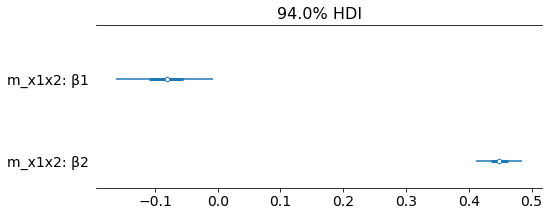

In [7]:
az.plot_forest([idata_x1x2],
               model_names=['m_x1x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))

## X1 is confounding
From the forest plot, we can identify that value of β1 is almost 0. This represents that X1 is a confounding variable and doesn't really add to the model's accuracy, all the while making the model more complex

## Multi-collinearity
As part of the strategies discussed in class, we need to *drop the variable X1* because it is a confounding variable.

We will redefine the model again with X2 only as we did in assignment 2

## Defining the model again by dropping the confounding variable

This time we'll only use X2 to reduce the unnecessary complexity of the model

In [13]:
with pm.Model() as model1:
  α = pm.Normal('α2', mu=0, sigma=10)
  β = pm.Normal('β2', mu=0, sigma=1)
  ε = pm.HalfCauchy('ε2', 5)
  μ = pm.Deterministic('μ1', α + β * X2)  # To include the origonal values in the trace
  y1_pred = pm.Normal('y1_pred', mu=μ, sigma=ε, observed=Y)
  trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [α2, β2, ε2]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


100.00% [2000/2000 00:05<00:00 Sampling chain 0, 0 divergences]

100.00% [2000/2000 00:07<00:00 Sampling chain 1, 0 divergences]

array([%lt;Axes: title={'center': '94.0% HDI'}%gt;], dtype=object)

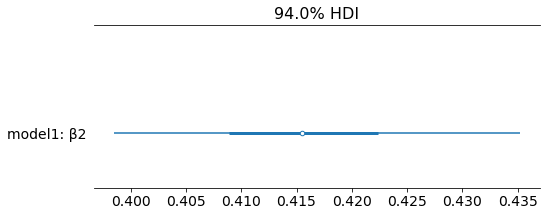

In [14]:
az.plot_forest([trace],
               model_names=['model1'],
               var_names=['β2'],
               combined=True, colors='cycle', figsize=(8, 3))

## Conclusion

Now our made has reduced complexity with about the same accuracy as the previous model because X1 wasn't really adding to the accuracy of the model